# ATTACKS Visualization

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ['SCIPY_USE_PROPACK'] = "True"
 
threads = "64"
os.environ["OMP_NUM_THREADS"] = threads
os.environ["OPENBLAS_NUM_THREADS"] = threads
os.environ["MKL_NUM_THREADS"] = threads
os.environ["VECLIB_MAXIMUM_THREADS"] = threads
os.environ["NUMEXPR_NUM_THREADS"] = threads

In [1]:
import torchattacks

import torch
from tensordict import TensorDict
from tensordict import MemoryMappedTensor as MMT

import abc  

In [2]:
# python stuff

from pathlib import Path as Path
from numpy.random import randint
from tqdm import tqdm

# Our stuff
from datasets.cifar import Cifar
from models.model_wrap import ModelWrap
from adv_atk.attacks_base import fds, ftd

# from credibility import get_credibility

# torch stuff
from torchvision.models import vgg16, VGG16_Weights
from cuda_selector import auto_cuda


use_cuda = torch.cuda.is_available()
cuda_index = torch.cuda.device_count() - 3
device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
print(f"Using {device} device")
# use_cuda = torch.cuda.is_available()
# device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device("cpu")
# print(f"Using {device} device")

# use_cuda = torch.cuda.is_available()
# cuda_index = 1
# device = torch.device(f"cuda:{cuda_index}" if use_cuda else "cpu")
# print(f"Using {device} device")

#--------------------------------
# Directories definitions
#--------------------------------
ds_path = '/srv/newpenny/dataset/CIFAR100'

# model parameters
pretrained = True
dataset = 'CIFAR100' 
seed = 29
bs = 64 
model_dir = '/srv/newpenny/XAI/models'
model_name = 'LM_model=vgg16_dataset=CIFAR100_augment=True_optim=SGD_scheduler=LROnPlateau.pth'

verbose = True

#--------------------------------
# Dataset 
#--------------------------------
# model parameters
name_model = 'vgg16'
dataset = 'CIFAR100' 
seed = 29
bs = 64

ds = Cifar(dataset=dataset, data_path=ds_path)
ds.load_data(
        batch_size = bs,
        data_kwargs = {'num_workers': 4, 'pin_memory': True},
        seed = seed,
        )

Using cuda:3 device
dataset: CIFAR100
Files already downloaded and verified
Files already downloaded and verified


{'train': <torch.utils.data.dataloader.DataLoader at 0x7f04c024eff0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f04c024f050>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f04c024f080>}

In [3]:
#--------------------------------
# Model 
#--------------------------------

nn = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_features = 4096
num_classes = len(ds.get_classes()) 
nn.classifier[-1] = torch.nn.Linear(in_features, num_classes)
model = ModelWrap(device=device)
model.set_model(model=nn, path=model_dir, name=model_name, verbose=True)

ds_loaders = ds.get_dataset_loaders()

/home/lorenzocapelli/repos/XAI/src/models/model_wrap.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._checkpoint = torch.load(file, map_location=self.device)



-----------------
checkpoint
-----------------
state_dict keys: 
 odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias']) 

epoch 58
initial_lr 0.001
final_lr 1e-05
train_accuracy 93.895
val_accuracy 95.53
loss_plot b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x06\x00\x00\x005\xd1\xdc\xe4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.9.2, 

## PGD

In [4]:
from adv_atk.PGD import myPGD

In [5]:
Path.cwd()

PosixPath('/home/lorenzocapelli/repos/XAI/src')

In [7]:
name = 'PGD'
path = f'/srv/newpenny/XAI/generated_data/attacks/{name}'

In [8]:
loader = {}
loader['test'] = ds_loaders['test']

In [9]:
kwargs = {'model': model._model,
          'eps' : 8/255, 
          'alpha' : 2/255, 
          'steps' : 10,
          'device' : device,
          'path' : path,
          'name' : name,
          'dl' : ds_loaders,
          'name_model' : name_model,
          'verbose' : True,
          'mode' : 'random', 
}

In [10]:
atk = myPGD(**kwargs)

---------- Attack PGD init

File /srv/newpenny/XAI/generated_data/attacks/PGD/model_vgg16/eps_0.03/alpha_0.01/steps_10/random_start_True exists.


In [27]:
atk.get_ds_attack()


 ---- Getting data from train



  0%|                                                   | 0/625 [00:00<?, ?it/s]


AttributeError: 'myPGD' object has no attribute 'atk'

## BIM

In [13]:
from adv_atk.BIM import myBIM

In [14]:
name = 'BIM'
path = f'/srv/newpenny/XAI/generated_data/attacks/{name}'

In [15]:
loader = {}
loader['test'] = ds_loaders['test']

In [16]:
kwargs = {'model': model._model,
          'eps' : 8/255, 
          'alpha' : 2/255, 
          'steps' : 10,
          'device' : device,
          'path' : path,
          'name' : name,
          'dl' : loader,
          'name_model' : name_model,
          'verbose' : True,
          'mode' : 'random'
}

In [17]:
atk = myBIM(**kwargs)

---------- Attack BIM init

File /srv/newpenny/XAI/generated_data/attacks/BIM/model_vgg16/eps_0.03/alpha_0.01/steps_10 exists.


In [19]:
atk._atkds

AttributeError: 'myBIM' object has no attribute '_atkds'

In [14]:
atk.get_ds_attack()


 ---- Getting data from train

loader n_samples:  40000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [11:53<00:00,  1.14s/it]



 ---- Getting data from val

loader n_samples:  10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:49<00:00,  1.08s/it]



 ---- Getting data from test

loader n_samples:  10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [02:48<00:00,  1.07s/it]


## CW

In [19]:
from adv_atk.CW import myCW

In [20]:
name = 'CW'
path = f'/srv/newpenny/XAI/generated_data/attacks/{name}'

In [21]:
path

'/srv/newpenny/XAI/generated_data/attacks/CW'

In [22]:
loader = {}
loader['test'] = ds_loaders['test']

In [23]:
kwargs = {'model': model._model,
          'device' : device,
          'path' : path,
          'name' : name,
          'dl' : loader,
          'name_model' : name_model,
          'verbose' : True,
          'nb_classes' : ds.config['num_classes'],
          'confidence': 0,
          'c_range': (1e-3, 1e10),
          'max_steps': 1000,
          'optimizer_lr': 1e-2,
          'verbose': True,}

In [24]:
atk = myCW(**kwargs)

---------- Attack CW init

File /srv/newpenny/XAI/generated_data/attacks/CW/model_vgg16/confidence_0/c_range_(0.001, 10000000000.0)/max_steps_1000/optimizer_lr_0.01 exists.


In [11]:
atk.get_ds_attack()


 ---- Getting data from test



100%|██████████████████████████████████████| 157/157 [4:42:15<00:00, 107.87s/it]


Saving test to /home/lorenzocapelli/repos/XAI/src/../data/attacks/CW/model_vgg16/confidence_0/c_range_(0.001, 10000000000.0)/max_steps_1000/optimizer_lr_0.01/test.


## DeepFool

In [26]:
from adv_atk.DeepFool import myDeepFool

In [27]:
name = 'DeepFool'
path = f'/srv/newpenny/XAI/generated_data/attacks/{name}'

In [28]:
loader = {}
loader['test'] = ds_loaders['test']

In [29]:
kwargs = {'model': model._model,
          'steps' : 50,
          'overshoot' : 0.02,
          'device' : device,
          'path' : path,
          'name' : name,
          'dl' : ds_loaders,
          'name_model' : name_model,
          'verbose' : True,
          }

In [30]:
atk = myDeepFool(**kwargs)

---------- Attack DeepFool init

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f04c024eff0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f04c024f050>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f04c024f080>}
File /srv/newpenny/XAI/generated_data/attacks/DeepFool/model_vgg16/steps_50/overshoot_0.02 exists.


In [16]:
atk.get_ds_attack()


 ---- Getting data from train

40000
loader n_samples:  40000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [23:18:11<00:00, 134.23s/it]


Saving train to /home/lorenzocapelli/repos/XAI/src/../data/attacks/DeepFool/model_vgg16/steps_50/overshoot_0.02/train.

 ---- Getting data from val

10000
loader n_samples:  10000


100%|██████████████████████████████████████████████████████████████████████████| 157/157 [5:56:35<00:00, 136.28s/it]


Saving val to /home/lorenzocapelli/repos/XAI/src/../data/attacks/DeepFool/model_vgg16/steps_50/overshoot_0.02/val.


# Computing corevectors for the attacks

In [11]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [12]:
PGD_loaders = {key: DataLoader(value, batch_size=bs, collate_fn = lambda x: x, shuffle=False) for key, value in atk._atkds.items()}

In [18]:
BIM_loaders = {key: DataLoader(value, batch_size=bs, collate_fn = lambda x: x, shuffle=False) for key, value in atk._atkds.items()}

In [25]:
CW_loaders = {key: DataLoader(value, batch_size=bs, collate_fn = lambda x: x, shuffle=False) for key, value in atk._atkds.items()}

In [31]:
DeepFool_loaders = {key: DataLoader(value, batch_size=bs, collate_fn = lambda x: x, shuffle=False) for key, value in atk._atkds.items()}

In [32]:
portion = 'test'

In [191]:
data_iter = iter(ds_loaders[portion])

images, labels = next(data_iter)

In [192]:
images = images.to(device)
output = model(images)
labels

tensor([49, 33, 72, 51, 71, 92, 15, 14, 23,  0, 71, 75, 81, 69, 40, 43, 92, 97,
        70, 53, 70, 49, 75, 29, 21, 16, 39,  8,  8, 70, 20, 61, 41, 93, 56, 73,
        58, 11, 25, 37, 63, 24, 49, 73, 56, 22, 41, 58, 75, 17,  4,  6,  9, 57,
         2, 32, 71, 52, 42, 69, 77, 27, 15, 65])

In [193]:
cifar100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

# Create a dictionary where each key is the numeric class and the value is the class name
class_dict = {i: cifar100_classes[i] for i in range(len(cifar100_classes))}

print(class_dict)

{0: 'apple', 1: 'aquarium_fish', 2: 'baby', 3: 'bear', 4: 'beaver', 5: 'bed', 6: 'bee', 7: 'beetle', 8: 'bicycle', 9: 'bottle', 10: 'bowl', 11: 'boy', 12: 'bridge', 13: 'bus', 14: 'butterfly', 15: 'camel', 16: 'can', 17: 'castle', 18: 'caterpillar', 19: 'cattle', 20: 'chair', 21: 'chimpanzee', 22: 'clock', 23: 'cloud', 24: 'cockroach', 25: 'couch', 26: 'crab', 27: 'crocodile', 28: 'cup', 29: 'dinosaur', 30: 'dolphin', 31: 'elephant', 32: 'flatfish', 33: 'forest', 34: 'fox', 35: 'girl', 36: 'hamster', 37: 'house', 38: 'kangaroo', 39: 'keyboard', 40: 'lamp', 41: 'lawn_mower', 42: 'leopard', 43: 'lion', 44: 'lizard', 45: 'lobster', 46: 'man', 47: 'maple_tree', 48: 'motorcycle', 49: 'mountain', 50: 'mouse', 51: 'mushroom', 52: 'oak_tree', 53: 'orange', 54: 'orchid', 55: 'otter', 56: 'palm_tree', 57: 'pear', 58: 'pickup_truck', 59: 'pine_tree', 60: 'plain', 61: 'plate', 62: 'poppy', 63: 'porcupine', 64: 'possum', 65: 'rabbit', 66: 'raccoon', 67: 'ray', 68: 'road', 69: 'rocket', 70: 'rose', 

In [194]:
labels[0].detach().cpu().numpy()

array(49)

In [195]:
labels_name = [class_dict[int(label.detach().cpu().numpy())] for label in labels]
np.array(labels_name)

array(['mountain', 'forest', 'seal', 'mushroom', 'sea', 'tulip', 'camel',
       'butterfly', 'cloud', 'apple', 'sea', 'skunk', 'streetcar',
       'rocket', 'lamp', 'lion', 'tulip', 'wolf', 'rose', 'orange',
       'rose', 'mountain', 'skunk', 'dinosaur', 'chimpanzee', 'can',
       'keyboard', 'bicycle', 'bicycle', 'rose', 'chair', 'plate',
       'lawn_mower', 'turtle', 'palm_tree', 'shark', 'pickup_truck',
       'boy', 'couch', 'house', 'porcupine', 'cockroach', 'mountain',
       'shark', 'palm_tree', 'clock', 'lawn_mower', 'pickup_truck',
       'skunk', 'castle', 'beaver', 'bee', 'bottle', 'pear', 'baby',
       'flatfish', 'sea', 'oak_tree', 'leopard', 'rocket', 'snail',
       'crocodile', 'camel', 'rabbit'], dtype='<U12')

In [196]:
preds = output.argmax(axis=1)
correct_pred = [(pred==label).detach().cpu().numpy() for pred, label in zip(preds, labels)]

In [197]:
np.array(correct_pred).T

array([False,  True,  True,  True,  True, False,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False])

In [198]:
PGD_iter = iter(PGD_loaders[portion])

atk_PGD = next(PGD_iter)

In [199]:
atk_PGD['attack_success']

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [200]:
BIM_iter = iter(BIM_loaders[portion])

atk_BIM = next(BIM_iter)

In [201]:
atk_BIM['attack_success']

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [210]:
CW_iter = iter(CW_loaders[portion])

atk_CW = next(CW_iter)

In [211]:
atk_CW['attack_success']

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [204]:
DF_iter = iter(DeepFool_loaders[portion])

atk_DF = next(DF_iter)

In [205]:
atk_DF['attack_success']

tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 1., 1.])

In [206]:
idx = []
for k in range(len(images)):
    if (int(atk_DF['attack_success'][k]) == 1)&(int(atk_PGD['attack_success'][k]) == 1)&(int(atk_BIM['attack_success'][k]) == 1)&(int(atk_CW['attack_success'][k]) == 1)&(np.array(correct_pred[k])==True):
        idx.append(int(k))

In [207]:
idx_ = np.array(idx)

labels_name = np.array(labels_name)

In [208]:
for i, name in zip(idx, labels_name[idx_]):
    print(i, name)

1 forest
2 seal
3 mushroom
12 streetcar
13 rocket
14 lamp
15 lion
17 wolf
21 mountain
22 skunk
23 dinosaur
24 chimpanzee
26 keyboard
27 bicycle
28 bicycle
30 chair
32 lawn_mower
34 palm_tree
36 pickup_truck
37 boy
38 couch
39 house
40 porcupine
41 cockroach
42 mountain
43 shark
46 lawn_mower
50 beaver
51 bee
52 bottle
53 pear
54 baby
56 sea
58 leopard
59 rocket
61 crocodile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3815686..1.9589837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.350196..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.392942..1.9757491].


mountain


[]

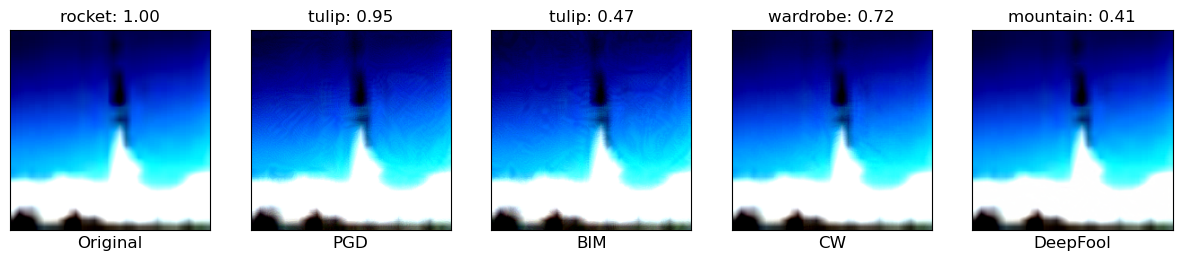

In [212]:
SM = torch.nn.Softmax()

fig, axs = plt.subplots(1,5,figsize=(15,8))
k=13

# Plot data on each subplot
axs[0].imshow(np.transpose(images[k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

output = SM(model(images))
pred = output.argmax(axis=1)[k]

axs[0].set_xlabel('Original', fontsize=12)  # Add label below each image
axs[0].set_xticks([])  # Remove x-axis ticks
axs[0].set_yticks([])  # Remove y-axis ticks

# Add titles to each subplot
axs[0].set_title(f'{labels_name[k]}: {output.max(dim=1)[0][k].detach().cpu().numpy():.2f}')

# Plot data on each subplot
axs[1].imshow(np.transpose(atk_PGD['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

atk = atk_PGD['image'].to(device)
output = SM(model(atk))
pred = output.argmax(axis=1)[k]
axs[1].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}: {output.max(dim=1)[0][k].detach().cpu().numpy():.2f}')
axs[1].set_xlabel('PGD', fontsize=12)  # Add label below each image
axs[1].set_xticks([])  # Remove x-axis ticks
axs[1].set_yticks([])  # Remove y-axis ticks

axs[2].imshow(np.transpose(atk_BIM['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

atk = atk_BIM['image'].to(device)
output = SM(model(atk))
pred = output.argmax(axis=1)[k]
axs[2].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}: {output.max(dim=1)[0][k].detach().cpu().numpy():.2f}')
axs[2].set_xlabel('BIM', fontsize=12)  # Add label below each image
axs[2].set_xticks([])  # Remove x-axis ticks
axs[2].set_yticks([])  # Remove y-axis ticks

axs[3].imshow(np.transpose(atk_CW['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

atk = atk_CW['image'].to(device)
output = SM(model(atk))
pred = output.argmax(axis=1)[k]
axs[3].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}: {output.max(dim=1)[0][k].detach().cpu().numpy():.2f}')
axs[3].set_xlabel('CW', fontsize=12)  # Add label below each image
axs[3].set_xticks([])  # Remove x-axis ticks
axs[3].set_yticks([])  # Remove y-axis ticks

axs[4].imshow(np.transpose(atk_DF['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

atk = atk_DF['image'].to(device)
output = SM(model(atk))
pred = output.argmax(axis=1)[k]
print(class_dict[int(pred.detach().cpu().numpy())])
axs[4].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}: {output.max(dim=1)[0][k].detach().cpu().numpy():.2f}')
axs[4].set_xlabel('DeepFool', fontsize=12)  # Add label below each image
axs[4].set_xticks([])  # Remove x-axis ticks
axs[4].set_yticks([])  # Remove y-axis ticks

In [213]:
fig.savefig('attacks_comparison.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1462744..1.3373857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1149019..1.0].


Text(0.5, 1.0, 'apple')

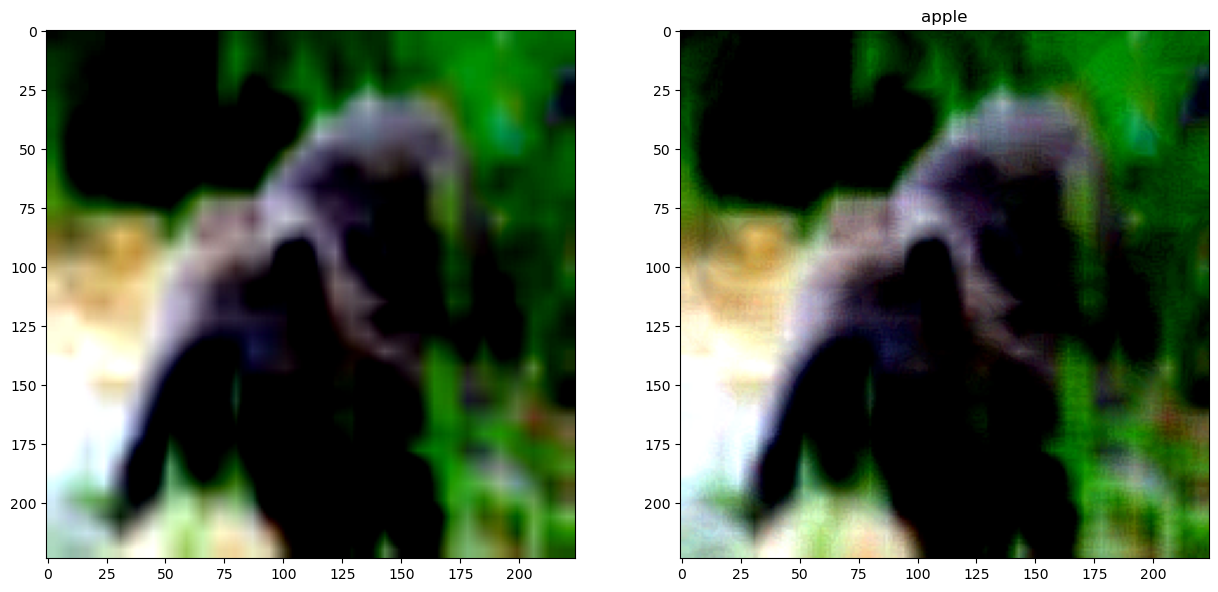

In [27]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
k=40

# Plot data on each subplot
axs[0].imshow(np.transpose(images[k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

# Add titles to each subplot
# axs[0].set_title(f'{labels_name[k]}')

# # Plot data on each subplot
# axs[1].imshow(np.transpose(atk_PGD['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

# atk = atk_PGD['image'].to(device)
# output = model(atk)
# pred = output.argmax(axis=1)[k]
# axs[1].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}')

axs[1].imshow(np.transpose(atk_BIM['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

atk = atk_BIM['image'].to(device)
output = model(atk)
pred = output.argmax(axis=1)[k]
axs[1].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}')

# axs[3].imshow(np.transpose(atk_CW['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

# atk = atk_CW['image'].to(device)
# output = model(atk)
# pred = output.argmax(axis=1)[k]
# axs[3].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}')

# axs[4].imshow(np.transpose(atk_DF['image'][k].squeeze().detach().cpu().numpy(), (1, 2, 0)))

# atk = atk_DF['image'].to(device)
# output = model(atk)
# pred = output.argmax(axis=1)[k]
# print(class_dict[int(pred.detach().cpu().numpy())])
# axs[4].set_title(f'{class_dict[int(pred.detach().cpu().numpy())]}')

In [68]:
softmax = torch.nn.Softmax()

In [73]:
softmax(output).max(axis=1)[0][40].detach().cpu().numpy()

array(0.99729544, dtype=float32)